In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv('./data/titanic/train.csv',dtype={"Age": np.float64})
test = pd.read_csv('./data/titanic/test.csv',dtype={"Age": np.float64})
submit = pd.read_csv('./data/titanic/gender_submission.csv')
PassengerId=test['PassengerId']

In [3]:
#合併train,test data 以利資料觀察 清洗
data=train.append(test)
data.reset_index(inplace=True,drop=True)
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


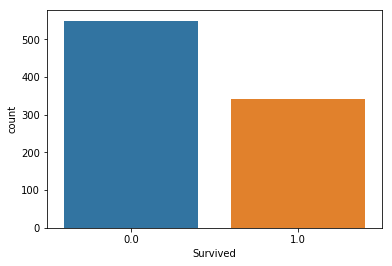

In [4]:
#觀察數據
#存活數量
sns.countplot(data['Survived'])

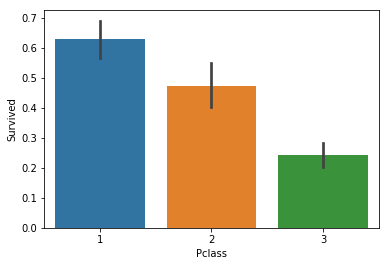

In [5]:

#艙等和存活率

sns.barplot(y=data['Survived'],x=data['Pclass'])

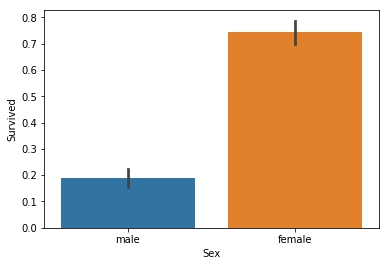

In [6]:
#性別和存活率
sns.barplot(y=data['Survived'],x=data['Sex'])

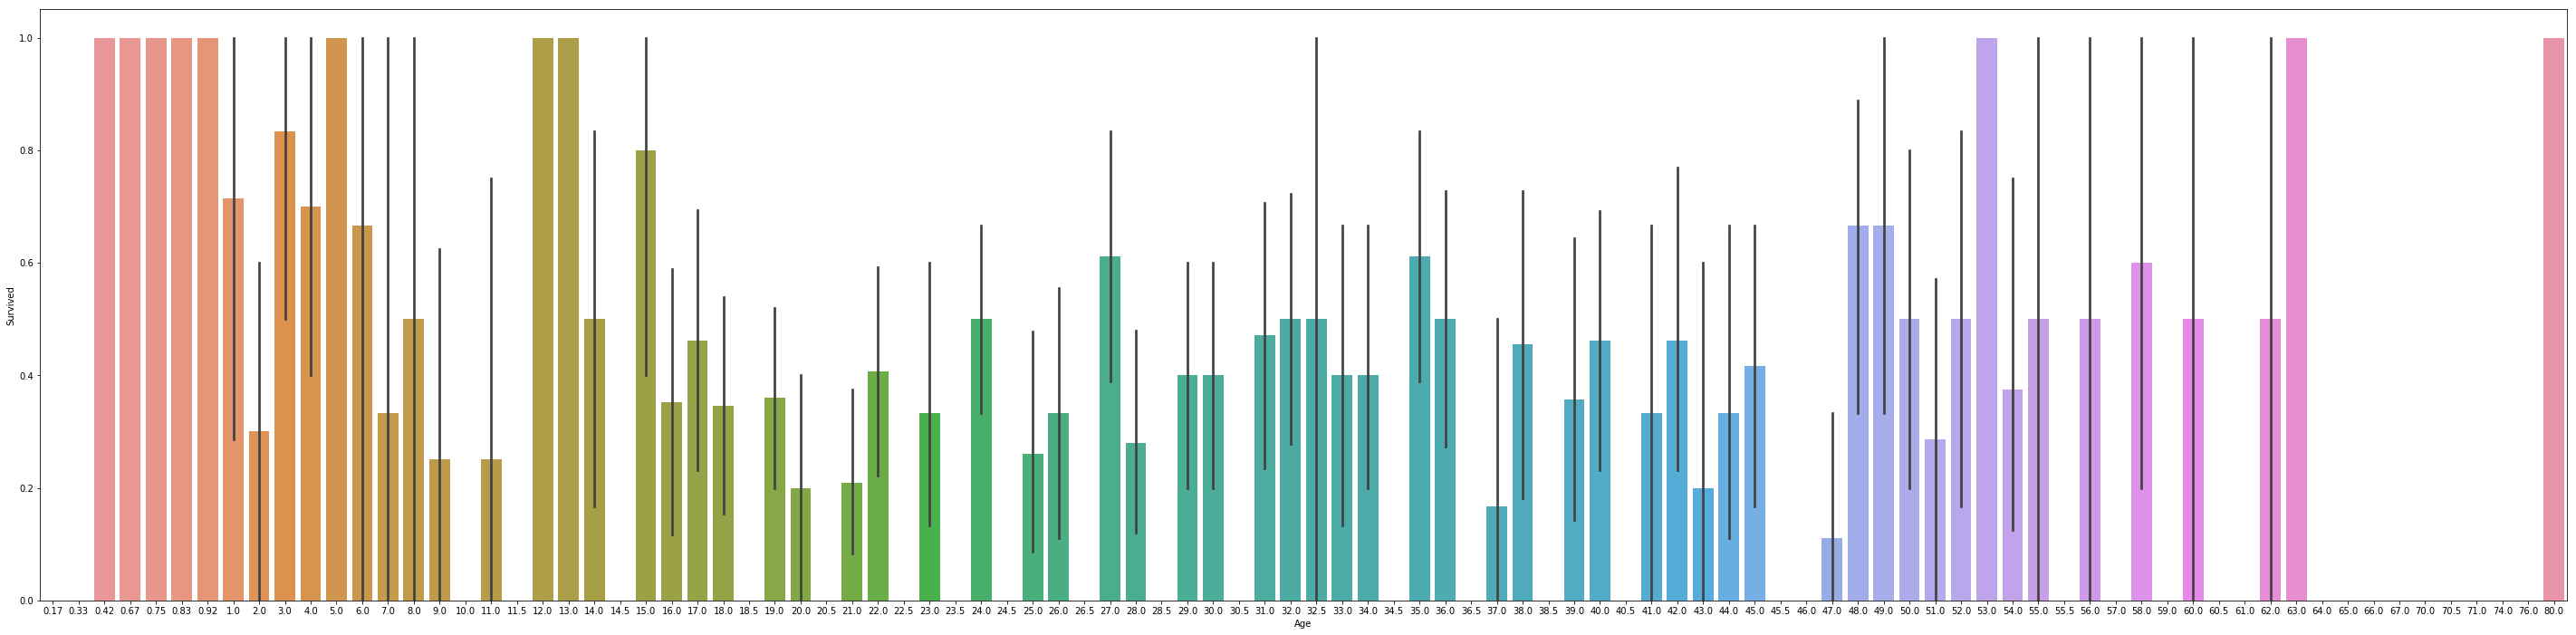

In [7]:
#年齡和存活率 (也許將年齡整理一下可以提高預測)
plt.figure(figsize=(50,12))
sns.barplot(y=data['Survived'],x=data['Age'])

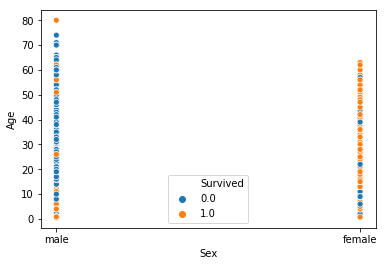

In [8]:
sns.scatterplot(x=data['Sex'],y=data['Age'],hue=data['Survived'])

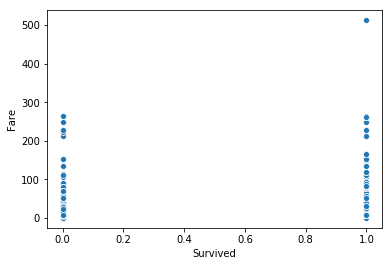

In [9]:
#票價和存活率較無關
sns.scatterplot(x=data['Survived'],y=data['Fare'])

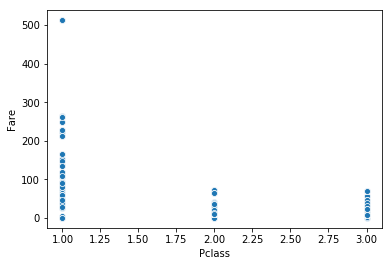

In [10]:
#觀察艙等和票價的關係，原本想說如果很像的話就刪掉一個
sns.scatterplot(x=data['Pclass'],y=data['Fare'])

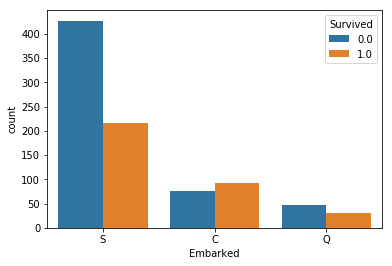

In [11]:
#embark 上船的地方 S港最多人死亡
sns.countplot(data['Embarked'],hue=data['Survived'])

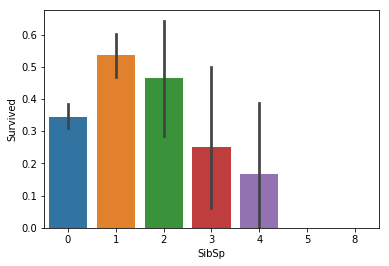

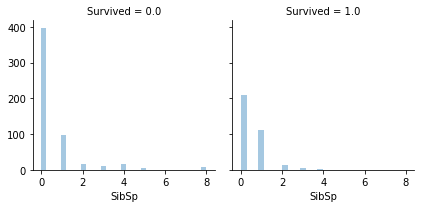

In [12]:
#兄弟姊妹配偶 數量越多存活率越低
sns.barplot(y=data['Survived'],x=data['SibSp'])
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'SibSp',kde=False)

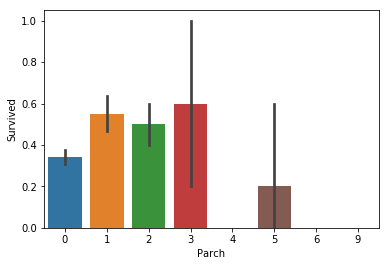

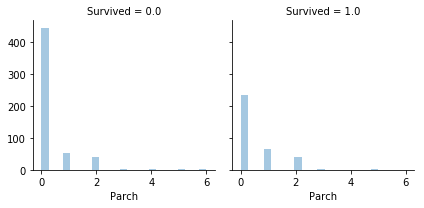

In [13]:
#有小孩數量 沒有小孩的比較容易死
sns.barplot(y=data['Survived'],x=data['Parch'])
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Parch',kde=False)

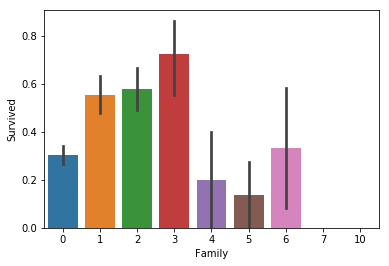

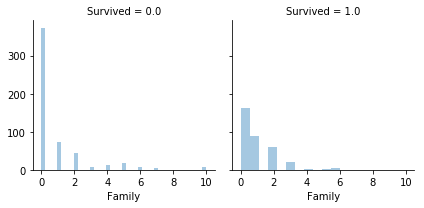

In [14]:
#由上述觀察可知 家人數量對於存活率是一樣的影響 越少越容易死亡 因此合併起來計算
data['Family']=data['Parch']+data['SibSp']
sns.barplot(y=data['Survived'],x=data['Family'])
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family',kde=False)

In [15]:
#資料前處理
#遺漏值處理
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Family         1309 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


In [16]:
#Embarked少一值用最多的S填補，Fare用平均值填補
data['Embarked']=data['Embarked'].fillna('S')
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

In [17]:
#cabin遺漏值最多 因此空值補NoCabin，並將資料一般化到第一個字母
data["Cabin"] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin')
data["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

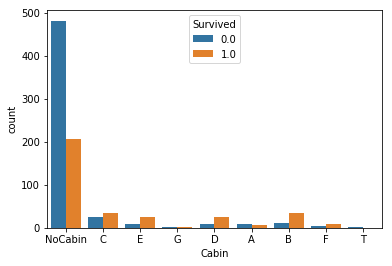

In [18]:
sns.countplot(data['Cabin'], hue=data['Survived'])

In [19]:
#特徵工程 一般化 正規化 類別資料轉換

In [20]:
#ticket 一般化到前面字母，可能代表位置，後面編號刪除
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [21]:
#Name一般化成 稱謂
data['Title1']=data['Name'].str.split(",",expand=True)[1]
data['Name'].str.split(",",expand=True).head(3)
data['Title1'].head(3)

0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
Name: Title1, dtype: object

In [22]:
data['Title1']=data['Title1'].str.split(".",expand=True)[0]
data['Title1'].head(3)

0       Mr
1      Mrs
2     Miss
Name: Title1, dtype: object

In [23]:
data['Title1'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

Sex,female,male
Title1,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


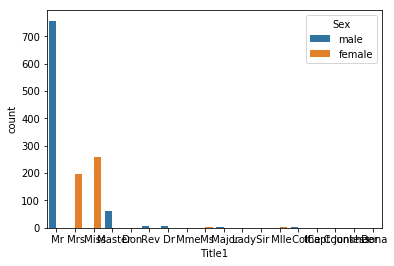

In [24]:
#分析稱謂和年齡的關係
sns.countplot(data['Title1'],hue=data['Sex'])
pd.crosstab(data['Title1'],data['Sex'])

In [25]:
#稱謂和年齡
data.groupby(['Title1'])['Age'].mean()

Title1
 Capt            70.000000
 Col             54.000000
 Don             40.000000
 Dona            39.000000
 Dr              43.571429
 Jonkheer        38.000000
 Lady            48.000000
 Major           48.500000
 Master           5.482642
 Miss            21.774238
 Mlle            24.000000
 Mme             24.000000
 Mr              32.252151
 Mrs             36.994118
 Ms              28.000000
 Rev             41.250000
 Sir             49.000000
 the Countess    33.000000
Name: Age, dtype: float64

In [26]:
#簡化稱謂 刪掉少數的
data['Title2'] = data['Title1'].replace(
    {'Mlle':'Miss','Mme':'Mrs','Ms':'Miss','Dr':'Mr','Major':'Mr','Lady':'Mrs','the Countess':'Mrs','Jonkheer':'Mr','Col':'Mr','Rev':'Mr','Capt':'Mr','Sir':'Mr','Don':'Mr','Dona':'Mrs'})


In [27]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [28]:
data['Title2'] = data['Title1'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
    ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs'           ,'Mr'      ,'Mr' ,'Mr' ,'Mr'  ,'Mr' ,'Mr' ,'Mrs'])

In [29]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [30]:
#類別資料轉數值資料
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes

In [31]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family,Ticket_info,Title1,Title2
0,22.0,7,2,7.2500,"Braund, Mr. Owen Harris",0,1,2,1,1,0.0,A/5 21171,1,2,12,12
1,38.0,2,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,0,1,1.0,PC 17599,1,14,13,13
2,26.0,7,2,7.9250,"Heikkinen, Miss. Laina",0,3,2,0,0,1.0,STON/O2. 3101282,0,31,9,9
3,35.0,2,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,0,1,1.0,113803,1,36,13,13
4,35.0,7,2,8.0500,"Allen, Mr. William Henry",0,5,2,1,0,0.0,373450,0,36,12,12


In [32]:
#年齡的填補用隨機森林來預測值
dataAgeNull = data[data["Age"].isnull()]
dataAgeNotNull = data[data["Age"].notnull()]
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
                      (np.abs(dataAgeNotNull["Family"]-dataAgeNotNull["Family"].mean())>(4*dataAgeNotNull["Family"].std()))                     
                     ]
rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title1', 'Title2','Cabin','Ticket_info']
rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
dataAgeNull.loc[:,"Age"] = ageNullValues
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace=True, drop=True)

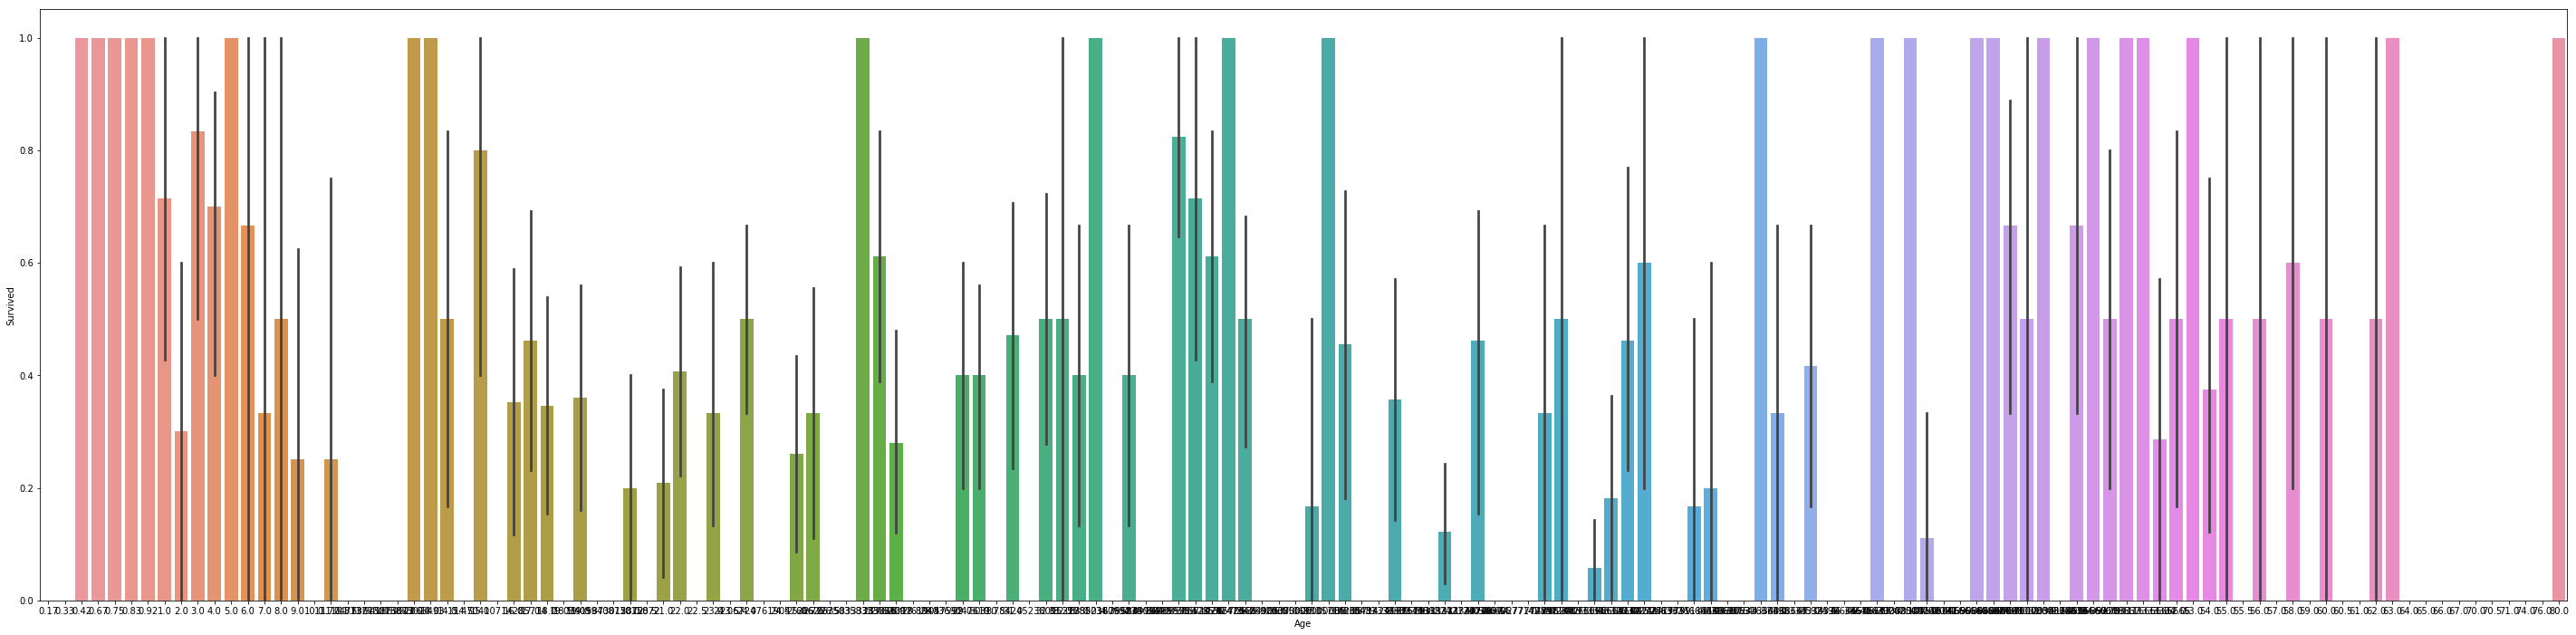

In [33]:
plt.figure(figsize=(50,12))
sns.barplot(y=data['Survived'],x=data['Age'])

In [34]:
#進行隨機森林預測生存率
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family', 'Ticket_info',
       'Title1', 'Title2'],
      dtype='object')

In [35]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',  'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTrain

,Survived,Age,Embarked,Fare,Pclass,Sex,Family,Title2,Ticket_info,Cabin
263,0.0,22.000000,2,7.2500,2,1,1,12,2,7
264,1.0,38.000000,0,71.2833,0,0,1,13,14,2
265,1.0,26.000000,2,7.9250,2,0,0,9,31,7
266,1.0,35.000000,2,53.1000,0,0,1,13,36,2
267,0.0,35.000000,2,8.0500,2,1,0,12,36,7
0,0.0,41.340767,1,8.4583,2,1,0,12,36,7
268,0.0,54.000000,2,51.8625,0,1,0,12,36,4
269,0.0,2.000000,2,21.0750,2,1,4,8,36,7
270,1.0,27.000000,2,11.1333,2,0,2,13,36,7
271,1.0,14.000000,0,30.0708,1,0,1,13,36,7


In [36]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8260


In [37]:
pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
4,Sex,0.276262
2,Fare,0.165452
6,Title2,0.143690
0,Age,0.135462
3,Pclass,0.088227
5,Family,0.069242
8,Cabin,0.064145
7,Ticket_info,0.031847
1,Embarked,0.025672


In [38]:
rf_res =  rf.predict(dataTest)
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit.csv', index= False)
submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
